In [1]:
!nvidia-smi

Mon Apr 23 21:18:17 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 390.48                 Driver Version: 390.48                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1080    Off  | 00000000:26:00.0  On |                  N/A |
| 22%   49C    P2    46W / 200W |    861MiB /  8118MiB |     19%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
# importing data science libraries
import pandas as pd

fraud_dataset = pd.read_csv('../data/nonames.csv')
print("There are ", len(fraud_dataset), " samples")
print(fraud_dataset.shape)
print(fraud_dataset.head(10))
print(fraud_dataset.describe())

There are  6362620  samples
(6362620, 12)
   step    amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
0     1   9839.64      170136.00       160296.36             0.0   
1     1   1864.28       21249.00        19384.72             0.0   
2     1    181.00         181.00            0.00             0.0   
3     1    181.00         181.00            0.00         21182.0   
4     1  11668.14       41554.00        29885.86             0.0   
5     1   7817.71       53860.00        46042.29             0.0   
6     1   7107.77      183195.00       176087.23             0.0   
7     1   7861.64      176087.23       168225.59             0.0   
8     1   4024.36        2671.00            0.00             0.0   
9     1   5337.77       41720.00        36382.23         41898.0   

   newbalanceDest  isFraud  CASH_IN  CASH_OUT  DEBIT  PAYMENT  TRANSFER  
0            0.00        0        0         0      0        1         0  
1            0.00        0        0         0      0        1

In [3]:
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

from keras import backend as K
K.set_session(sess)

/opt/anaconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
RANDOM_SEED = 42

In [5]:
X_train, X_test = train_test_split(fraud_dataset, test_size=0.2, random_state=RANDOM_SEED)
print("X_train: ", X_train.shape)
# y_train = X_train["isFraud"].copy(deep=True)
X_train.pop("isFraud")
print("X_train: ", X_train.shape)
X_train, X_val = train_test_split(X_train, test_size=0.2, random_state=RANDOM_SEED)
print("X_train: ", X_train.shape)
print("X_val: ", X_val.shape)
print("X_test: ", X_test.shape)
y_test = X_test["isFraud"].copy(deep=True)
X_test.pop("isFraud")
print("X_test: ", X_test.shape)

X_train:  (5090096, 12)
X_train:  (5090096, 11)
X_train:  (4072076, 11)
X_val:  (1018020, 11)
X_test:  (1272524, 12)
X_test:  (1272524, 11)


In [6]:
input_shape = X_train.shape[1]

hidden_layer = [10, 8, 4]
input_layer = Input(shape=(input_shape,))
encoder1 = Dense(hidden_layer[0], activation="relu")(input_layer)
encoder2 = Dense(hidden_layer[1], activation="relu")(encoder1)
encoder3 = Dense(hidden_layer[2], activation="relu")(encoder2)
decoder1 = Dense(hidden_layer[2], activation="relu")(encoder3)
decoder2 = Dense(hidden_layer[1], activation="relu")(decoder1)
decoder3 = Dense(input_shape, activation="relu")(decoder2)
autoencoder = Model(inputs=input_layer, outputs=decoder3)

In [7]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 11)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                120       
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 88        
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 40        
_________________________________________________________________
dense_6 (Dense)              (None, 11)                99        
Total para

In [8]:
nb_epoch = 200
batch_size = 1000
# using mean squared error
autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath="../saved/basicAE2.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)
history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_val, X_val),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Train on 4072076 samples, validate on 1018020 samples
Epoch 1/200
4072076/4072076 [==============================] - 23s 6us/step - loss: 1074972479081.5903 - acc: 0.5876 - val_loss: 45597213088.5526 - val_acc: 0.6759
Epoch 2/200
4072076/4072076 [==============================] - 22s 5us/step - loss: 39841412444.0861 - acc: 0.7925 - val_loss: 37548051843.9053 - val_acc: 0.7912
Epoch 3/200
4072076/4072076 [==============================] - 22s 5us/step - loss: 37278299802.1287 - acc: 0.7476 - val_loss: 37275732397.6290 - val_acc: 0.7134
Epoch 4/200
4072076/4072076 [==============================] - 22s 6us/step - loss: 37119754922.8967 - acc: 0.6947 - val_loss: 37257892249.7529 - val_acc: 0.6992
Epoch 5/200
4072076/4072076 [==============================] - 22s 5us/step - loss: 37151848854.9902 - acc: 0.8024 - val_loss: 37331357235.7120 - val_acc: 0.8134
Epoch 6/200
4072076/4072076 [==============================] - 23s 6us/step - loss: 37055934749.9683 - acc: 0.8378 - val_loss: 3724051

4072076/4072076 [==============================] - 24s 6us/step - loss: 538544178.9434 - acc: 0.9162 - val_loss: 364664193.4404 - val_acc: 0.9164
Epoch 52/200
4072076/4072076 [==============================] - 23s 6us/step - loss: 495768430.8961 - acc: 0.9172 - val_loss: 371384239.8193 - val_acc: 0.9193
Epoch 53/200
4072076/4072076 [==============================] - 24s 6us/step - loss: 479059578.7250 - acc: 0.9172 - val_loss: 359785433.3579 - val_acc: 0.9236
Epoch 54/200
4072076/4072076 [==============================] - 23s 6us/step - loss: 477367126.6921 - acc: 0.9189 - val_loss: 355465943.0534 - val_acc: 0.9078
Epoch 55/200
4072076/4072076 [==============================] - 24s 6us/step - loss: 427716750.6369 - acc: 0.9163 - val_loss: 459700868.5547 - val_acc: 0.9008
Epoch 56/200
4072076/4072076 [==============================] - 24s 6us/step - loss: 612469642.3985 - acc: 0.9209 - val_loss: 389622887.8697 - val_acc: 0.9140
Epoch 57/200
4072076/4072076 [=============================

4072076/4072076 [==============================] - 24s 6us/step - loss: 446256407.4015 - acc: 0.9028 - val_loss: 329513900.6572 - val_acc: 0.9138
Epoch 103/200
4072076/4072076 [==============================] - 24s 6us/step - loss: 393628118.9801 - acc: 0.9033 - val_loss: 353126616.9818 - val_acc: 0.8832
Epoch 104/200
4072076/4072076 [==============================] - 24s 6us/step - loss: 374716374.5355 - acc: 0.9021 - val_loss: 457096945.3448 - val_acc: 0.9042
Epoch 105/200
4072076/4072076 [==============================] - 23s 6us/step - loss: 397742881.6923 - acc: 0.9025 - val_loss: 1322910626.6203 - val_acc: 0.8779
Epoch 106/200
4072076/4072076 [==============================] - 24s 6us/step - loss: 438433028.4023 - acc: 0.9062 - val_loss: 383887059.7550 - val_acc: 0.9146
Epoch 107/200
4072076/4072076 [==============================] - 24s 6us/step - loss: 389497295.5420 - acc: 0.9075 - val_loss: 423177343.7177 - val_acc: 0.9043
Epoch 108/200
4072076/4072076 [======================

4072076/4072076 [==============================] - 23s 6us/step - loss: 396558923.4216 - acc: 0.8948 - val_loss: 306013982.7212 - val_acc: 0.9107
Epoch 154/200
4072076/4072076 [==============================] - 23s 6us/step - loss: 340708814.5072 - acc: 0.8943 - val_loss: 338864273.5391 - val_acc: 0.8937
Epoch 155/200
4072076/4072076 [==============================] - 23s 6us/step - loss: 393803534.8627 - acc: 0.8894 - val_loss: 1618757860.0971 - val_acc: 0.8472
Epoch 156/200
4072076/4072076 [==============================] - 23s 6us/step - loss: 377795182.1879 - acc: 0.8966 - val_loss: 1586044175.5068 - val_acc: 0.8941
Epoch 157/200
4072076/4072076 [==============================] - 23s 6us/step - loss: 425871648.8829 - acc: 0.8973 - val_loss: 317125719.4910 - val_acc: 0.8894
Epoch 158/200
4072076/4072076 [==============================] - 23s 6us/step - loss: 382281449.8546 - acc: 0.8974 - val_loss: 2022566113.0027 - val_acc: 0.8642
Epoch 159/200
4072076/4072076 [====================

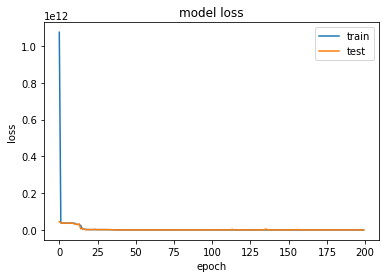

In [9]:
# importing visualization tools
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

autoencoder = load_model('../saved/basicAE2.h5')

plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

In [16]:
import numpy as np

predictions = autoencoder.predict(X_test)
# calculate my own MSE
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse})
error_df.describe()
print(predictions.shape)

(1272524, 11)


In [20]:
print(predictions[0][:])
X_test.head(1)

[     0.    322819.7    28919.469 348633.75  462520.88  123339.32
      0.         0.         0.         0.         0.   ]


,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER
3737323,278,330218.42,20866.0,351084.42,452419.57,122201.15,1,0,0,0,0
